# Project Overview


<img src="images/pld3280-fig-0001-m.jpg" width="800" height="600">

# Testing the various thresholding methods

## Otsu thresholding, post processing, and display
## vs Adaptive thresholding, post processing, and display 
## vs Adaptive Gaussian thresholding, post processing, and display


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas
import glob

def load_gray_image(image_path):
    print(f"Loading image from {image_path}")
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def load_images_from_metadata(metadata_path, image_dir):
    """
    roi_metadata_path = "rois_metadata_bignine.csv"
    image_dir = "rois
    """
    all_images = []
    
    # load the df and print the first few rows
    metadata = pandas.read_csv(metadata_path)
    
    # if the df is empty, return an empty, throw
    if len(metadata) == 0:
        raise ValueError(f"No metadata found in {metadata_path}")
    else:
        print(f"Loaded metadata from {metadata_path}, with {len(metadata)} rows")
    
    for image_number in len(metadata):
        image = load_gray_image(images[image_number])
        all_images.extend(image)
    
    return all_images

def equalize_image(image, clip_low=100, clip_high=255):
    equalized = cv2.equalizeHist(image)
    equalized = np.clip(equalized, clip_low, clip_high)
    return equalized

def gauss_blur(image, ksize=(5, 5), sigmaX=0):
    return cv2.GaussianBlur(image, ksize, sigmaX)

def morphological_filter(image, th_low=0, th_high=255):
    closing1 = cv2.morphologyEx(image, cv2.MORPH_CLOSE, closing_kernel, iterations=closing_iterations)
    opening2 = cv2.morphologyEx(closing1, cv2.MORPH_OPEN, opening_kernel, iterations=opening_iterations)
    return opening2

## Otsu thresholding, post processing, and display
def otsu_threshold(image, th_low=0, th_high=255):
    _, thresholded = cv2.threshold(image, th_low, th_high, cv2.THRESH_OTSU)
    return thresholded

def adaptive_threshold(image, th_low=0, th_high=255):
    thresholded = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,25, 2)
    return thresholded

def adaptive_gaussian_threshold(image, th_low=0, th_high=255):
    thresholded = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25, 2)
    return thresholded

def add_color_overlay_to_lumen(image, overlay, alpha=0.3, color=(0, 255, 0)):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Create the overlay_mask, where the overlay is color and everything else is black
    overlay_mask = np.zeros_like(image)
    overlay_mask[overlay == 255] = color   
    
    # add the overlay to the image
    cv2.addWeighted(overlay_mask, alpha, image, 1 - alpha, 0, image)
    
    print(f"image shape: {image.shape}")
    
    # return the image with the overlay
    return image


def add_membrane_overlay(image, overlay, color=(0, 0, 0)):
    """
    Show the original grayscale image wherever the overlay is white, and color (black) wherever the overlay is black.

    Args:
    - image: Grayscale input image (2D array).
    - overlay: Binary mask (2D array, same size as image).
    - color: Tuple representing the color to display where the overlay is black.

    Returns:
    - Image with the mask applied.
    """
    # Ensure the input image is grayscale and convert to BGR
    if len(image.shape) == 2:  # Check if image is grayscale
        image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_bgr = image  # Already in BGR format

    # Create a mask for the areas to be blacked out (where overlay is 0)
    mask_inv = cv2.bitwise_not(overlay)

    # Convert the binary mask to a 3-channel BGR format
    mask_inv_bgr = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)

    # Create an image with the color (black by default) in areas where the overlay is black
    color_image = np.full_like(image_bgr, color, dtype=np.uint8)

    # Use the mask to combine the original image and the color image
    result = cv2.bitwise_and(image_bgr, mask_inv_bgr) + cv2.bitwise_and(color_image, cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR))

    return result

def process_image(image, method, equalize=True, blur=True, metadata=None):
    if equalize:
        image = equalize_image(image, clip_low=0, clip_high=255)
    if blur:
        image = gauss_blur(image, ksize=(5, 5), sigmaX=0)
    if method == "otsu":
        thresholded = otsu_threshold(image)
    elif method == "adaptive":
        thresholded = adaptive_threshold(image)
    elif method == "adaptive_gaussian":
        thresholded = adaptive_gaussian_threshold(image)
    else:
        raise ValueError(f"Method {method} not recognized")

    morphed = morphological_filter(thresholded)
    overlayed = add_membrane_overlay(image, morphed)
    
    return {"method": method,
            "blur": blur,
            "equalize": equalize,
            "metadata": metadata,
            "image": image, "thresholded": thresholded, "morphed": morphed, "overlayed": overlayed}
    
        
def get_raw_images(metadata_path, image_dir):
    
    metadata = pandas.read_csv(metadata_path)
    strip_filenames = metadata['strip_filename'].tolist()
    images = [image_dir + strip_filename for strip_filename in strip_filenames]
    
    return images


def remove_end_slash(path):
    # lambda to remove trailing slash from mask_output_dir if needed
    remove_end_slash = lambda path: path if not path.endswith("/") else path[:-1]

    return remove_end_slash(path)

def get_filename(base_path, suptitle, strip: str):
    print("get_filename() got strip = ", strip)
    output_dir = remove_end_slash(base_path)
    os.makedirs(output_dir, exist_ok=True)

    output_filename =  f"{output_dir}/{suptitle.replace(' ', '_').replace(',', '')}_strip_{strip}.png"

def save_membrane_mask(base_path, image_dict, suptitle, strip):
    """
    save_membrane_mask(image_dict, suptitle, image_dict['metadata']['strip'].values[0])
    
    Save the membrane mask (image_dict['morphed']) to a file, with a name that includes the suptitle and strip number.
    
    Ensures that the output directory exists.
    
    """
    mask_output_path = f"{os.getcwd()}/{remove_end_slash(base_path)}/masks/{suptitle.replace(' ', '_').replace(',', '')}"
    os.makedirs(mask_output_path, exist_ok=True)    
    cv2.imwrite(f"{mask_output_path}/strip_{strip}.png", image_dict['morphed'])


# function to take blur and non blur and create a plot of them
def plot_images(base_path:str, image_dict:dict, titles=None, display_image=True):
    if titles is None:
        titles = ["Original","Thresholded", "Morphed", "Overlayed"]
    suptitle = f"{image_dict['method']} thresholding, {'blurred' if image_dict['blur'] else 'not blurred'}, {'equalized' if image_dict['equalize'] else 'not equalized'}"
    images = [image_dict["image"], image_dict["thresholded"], image_dict["morphed"], image_dict["overlayed"]]
    fig, axes = plt.subplots(1, 4, figsize=(12, 5.5), facecolor='white')
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(titles[i])
    plt.tight_layout()
    plt.suptitle(suptitle, fontsize=16)

    # save just the membrane image, so we can use it later
    save_membrane_mask(base_path, image_dict,suptitle, image_dict['metadata']['strip'].values[0])

    # save the comparison of raw and processed images step by step to a file in base_path / method_comparison
    comparison_output_path = f"{os.getcwd()}/{remove_end_slash(base_path)}/method_comparison"
    os.makedirs(comparison_output_path, exist_ok=True)
    
    filename = f"{comparison_output_path}/{suptitle.replace(' ', '_').replace(',', '')}_strip_{image_dict['metadata']['strip'].values[0]}.png"
    print(f"Saving image to {filename}")    
    plt.savefig(filename)
    
    if display_image:
        plt.show()
    else:
        plt.close()
    

In [4]:
# Helmut chose 9 strips
chosen_strip_numbers = [101, 106, 134, 135, 161, 176, 187, 229, 232]

# parameters for the image processing
closing_kernel = np.ones((1, 7), np.uint8)
opening_kernel = np.ones((1, 5), np.uint8)
closing_iterations = 1
opening_iterations = 1
th_low = 0
th_high = 130
trial_number = 1
base_path = f"output/trial_{trial_number}/processed_images/"
roi_metadata_path = "rois_metadata_bignine.csv"
image_dir = f"output/trial_{trial_number}/rois/"
roi_metadata = pandas.read_csv(roi_metadata_path)

In [5]:
# ensure the directory exists
os.makedirs(base_path, exist_ok=True)

# take the image that corresponds to the strip number
strip_num = 101
strip_filename = roi_metadata[roi_metadata['strip'] == strip_num]['strip_filename'].values[0]

# isolate the dataframe row that corresponds to the strip number
metadata = roi_metadata[roi_metadata['strip'] == strip_num]

# start the loading process
image = load_gray_image(image_dir + strip_filename)

# Case 1: gaussian blur, otsu thresholding, morphological filtering
# case 2: no blur, otsu thresholding, morphological filtering
# Case 3: gaussian blur, adaptive thresholding, morphological filtering
# Case 4: no blur, adaptive thresholding, morphological filtering
# Case 5: gaussian blur, adaptive gaussian thresholding, morphological filtering
# Case 6: no blur, adaptive gaussian thresholding, morphological filtering

titles = ["Original","Thresholded", "Morphed", "Isolated Membrane"]

plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=True, equalize=True, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=False, equalize=True, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=True, equalize=False, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=False, equalize=False, metadata=metadata), titles=titles, display_image=False)

plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=True, equalize=True, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=False, equalize=True, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=True, equalize=False, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=False, equalize=False, metadata=metadata), titles=titles, display_image=False)

plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=True, equalize=True, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=False, equalize=True, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=True, equalize=False, metadata=metadata), titles=titles, display_image=False)
plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=False, equalize=False, metadata=metadata), titles=titles, display_image=False)


Loading image from output/trial_1/rois/strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_not_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_blurred_not_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_not_blurred_not_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/adaptive_thresholding_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/adaptive_thresholding_not_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_

# Do the above for all chosen strip numbers

In [6]:
for strip_num in chosen_strip_numbers:

    strip_filename = roi_metadata[roi_metadata['strip'] == strip_num]['strip_filename'].values[0]

    # isolate the dataframe row that corresponds to the strip number
    metadata = roi_metadata[roi_metadata['strip'] == strip_num]

    # start the loading process
    image = load_gray_image(image_dir + strip_filename)

    # Case 1: gaussian blur, otsu thresholding, morphological filtering
    # case 2: no blur, otsu thresholding, morphological filtering
    # Case 3: gaussian blur, adaptive thresholding, morphological filtering
    # Case 4: no blur, adaptive thresholding, morphological filtering
    # Case 5: gaussian blur, adaptive gaussian thresholding, morphological filtering
    # Case 6: no blur, adaptive gaussian thresholding, morphological filtering

    titles = ["Original","Thresholded", "Morphed", "Isolated Membrane"]

    plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=True, equalize=True, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=False, equalize=True, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=True, equalize=False, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "otsu", blur=False, equalize=False, metadata=metadata), titles=titles, display_image=False)

    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=True, equalize=True, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=False, equalize=True, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=True, equalize=False, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive", blur=False, equalize=False, metadata=metadata), titles=titles, display_image=False)

    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=True, equalize=True, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=False, equalize=True, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=True, equalize=False, metadata=metadata), titles=titles, display_image=False)
    plot_images(base_path=base_path, image_dict=process_image(image, "adaptive_gaussian", blur=False, equalize=False, metadata=metadata), titles=titles, display_image=False)

Loading image from output/trial_1/rois/strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_not_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_blurred_not_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/otsu_thresholding_not_blurred_not_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/adaptive_thresholding_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_images/method_comparison/adaptive_thresholding_not_blurred_equalized_strip_101.png
Saving image to d:\repos\gapfinder_images/output/trial_1/processed_

Loading image from output/trial_1/rois/strip_101.png
Image shape: (80, 60)


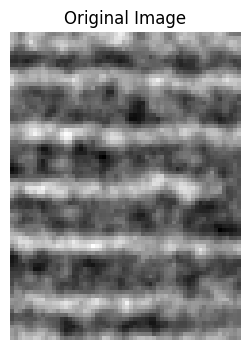

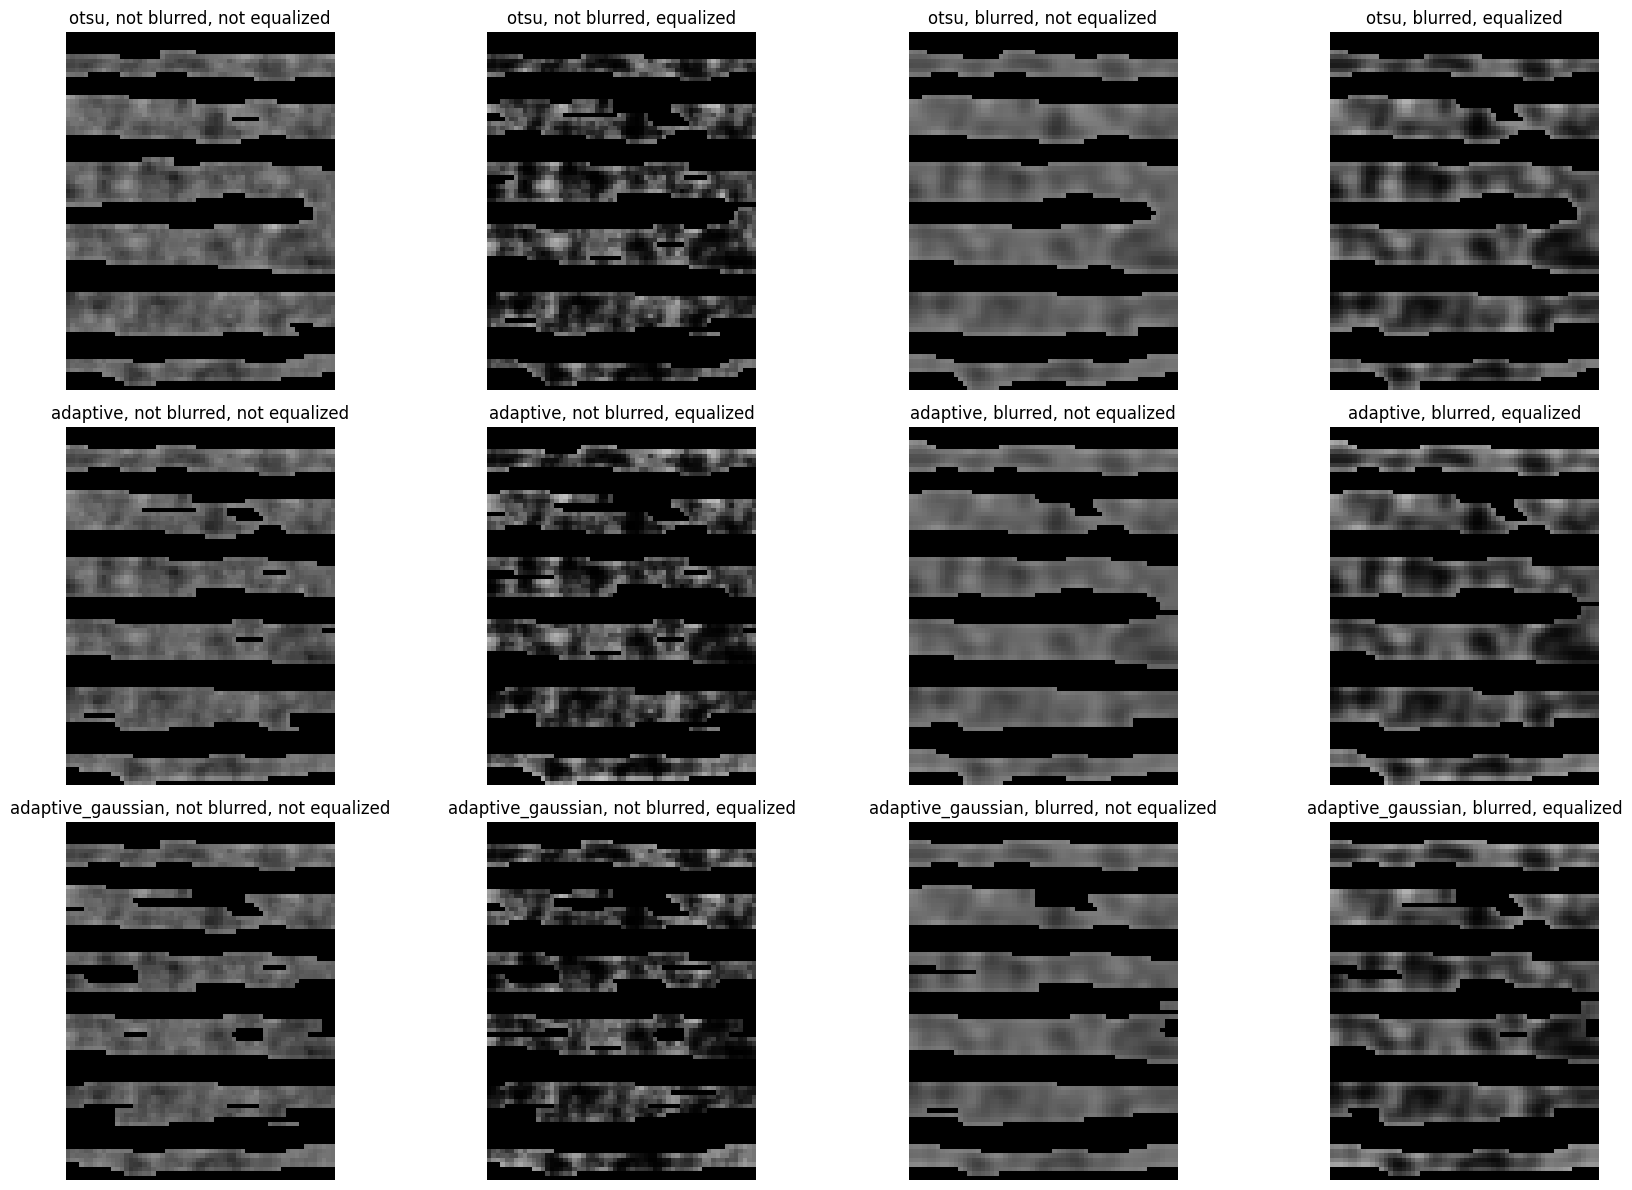

Loading image from output/trial_1/rois/strip_106.png
Image shape: (129, 60)


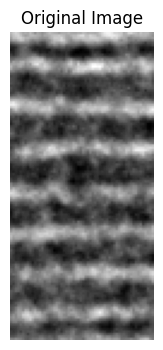

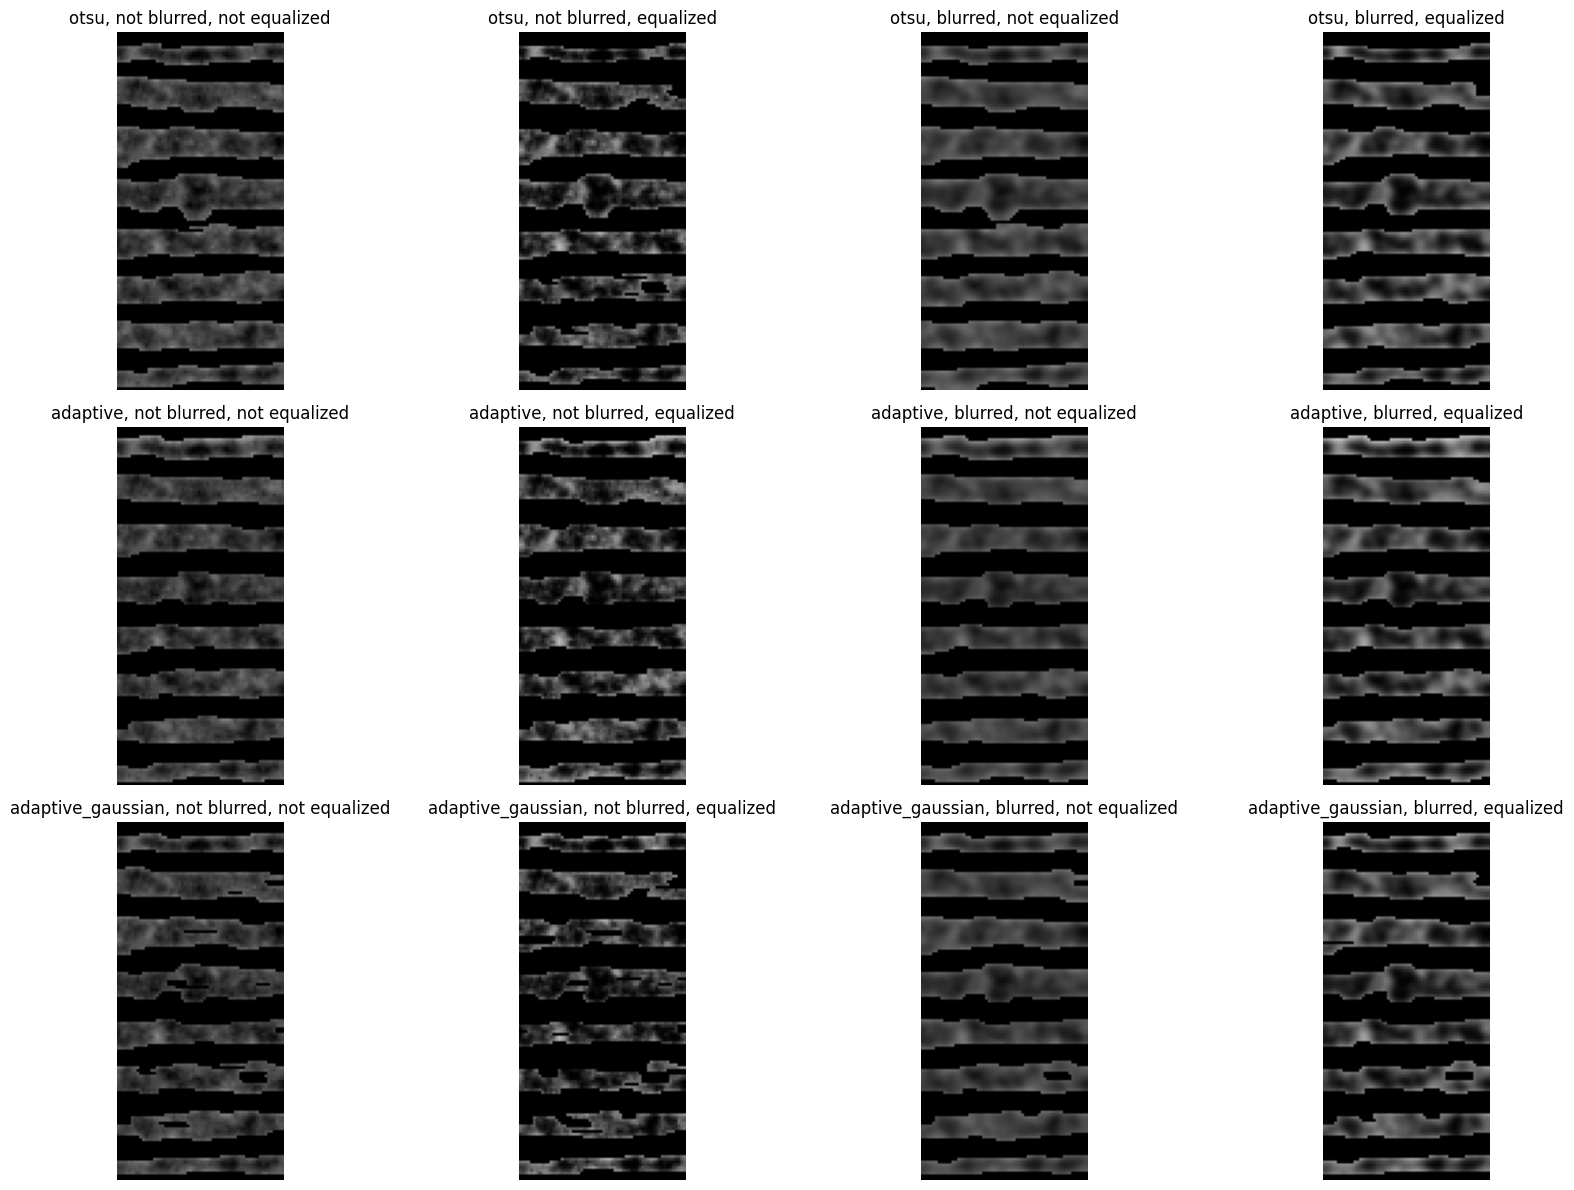

Loading image from output/trial_1/rois/strip_134.png
Image shape: (74, 60)


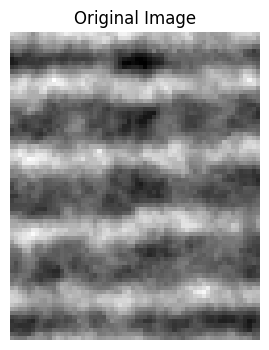

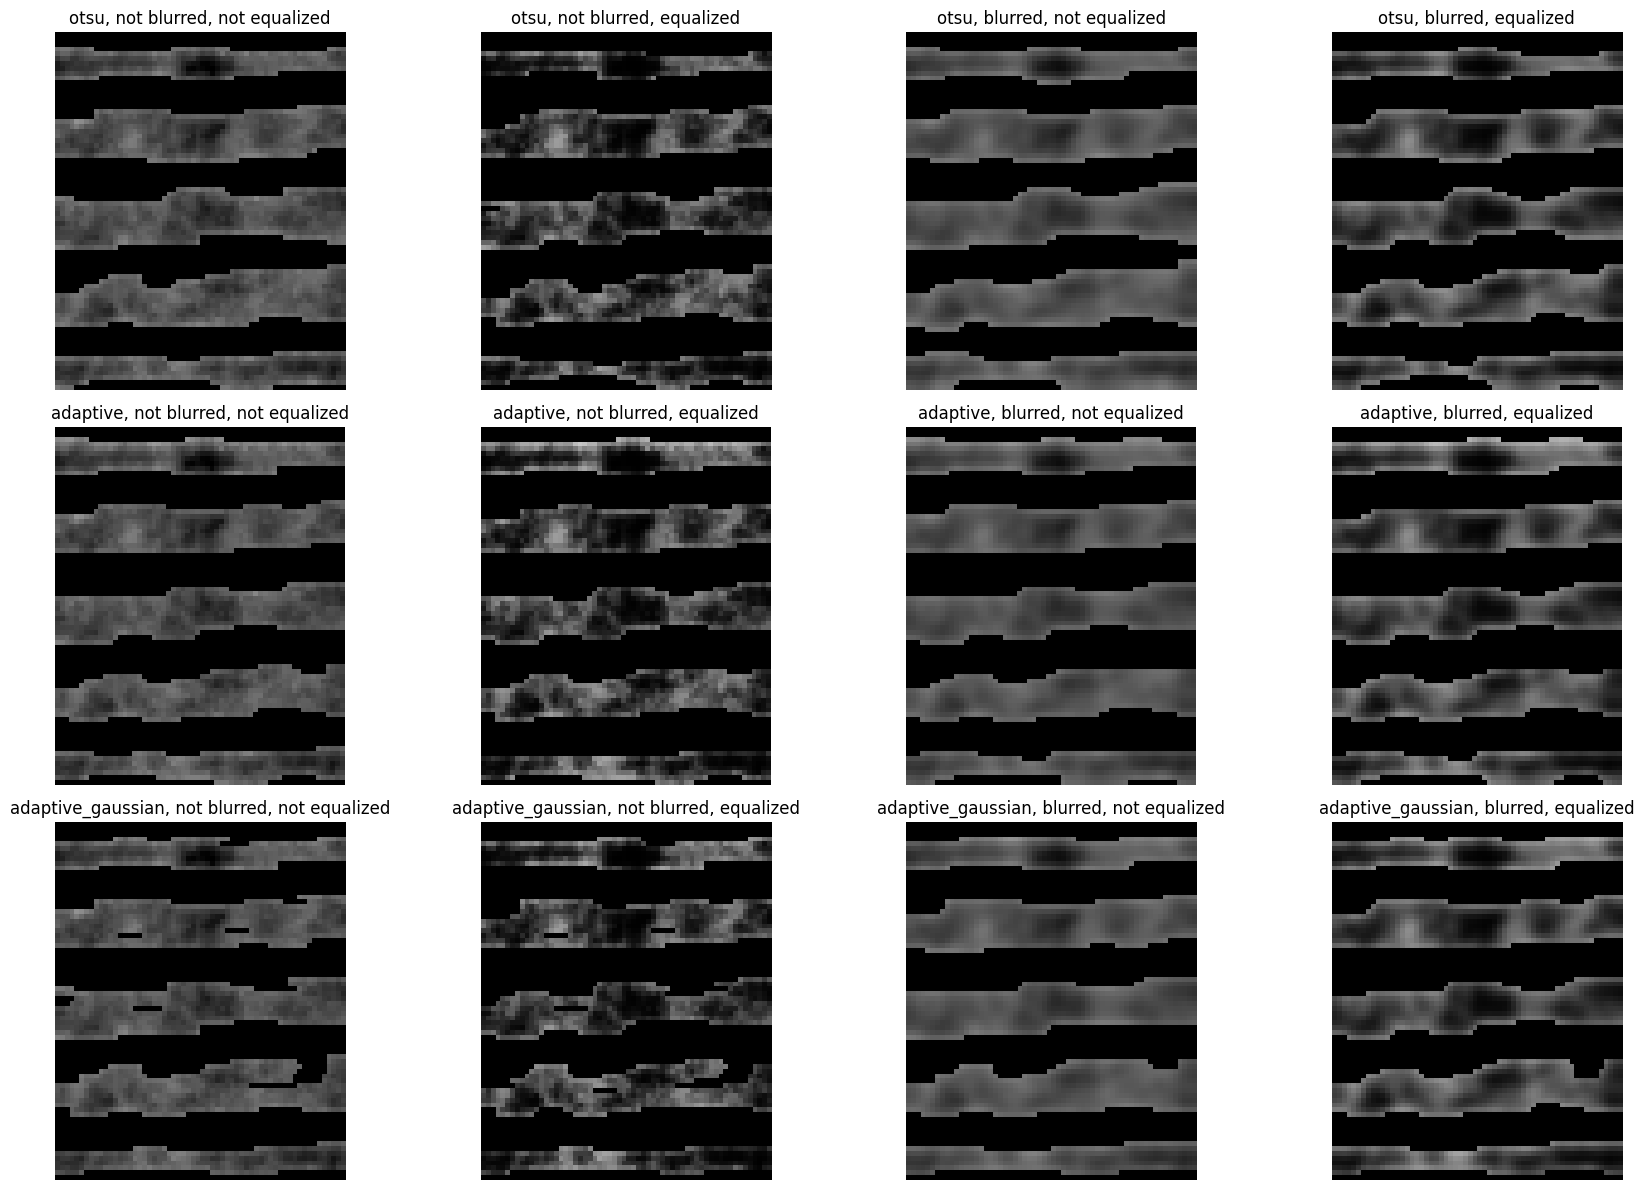

Loading image from output/trial_1/rois/strip_135.png
Image shape: (76, 60)


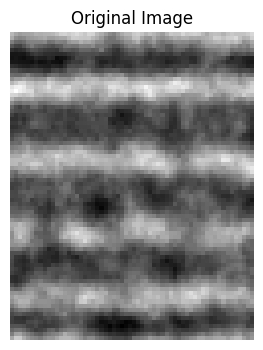

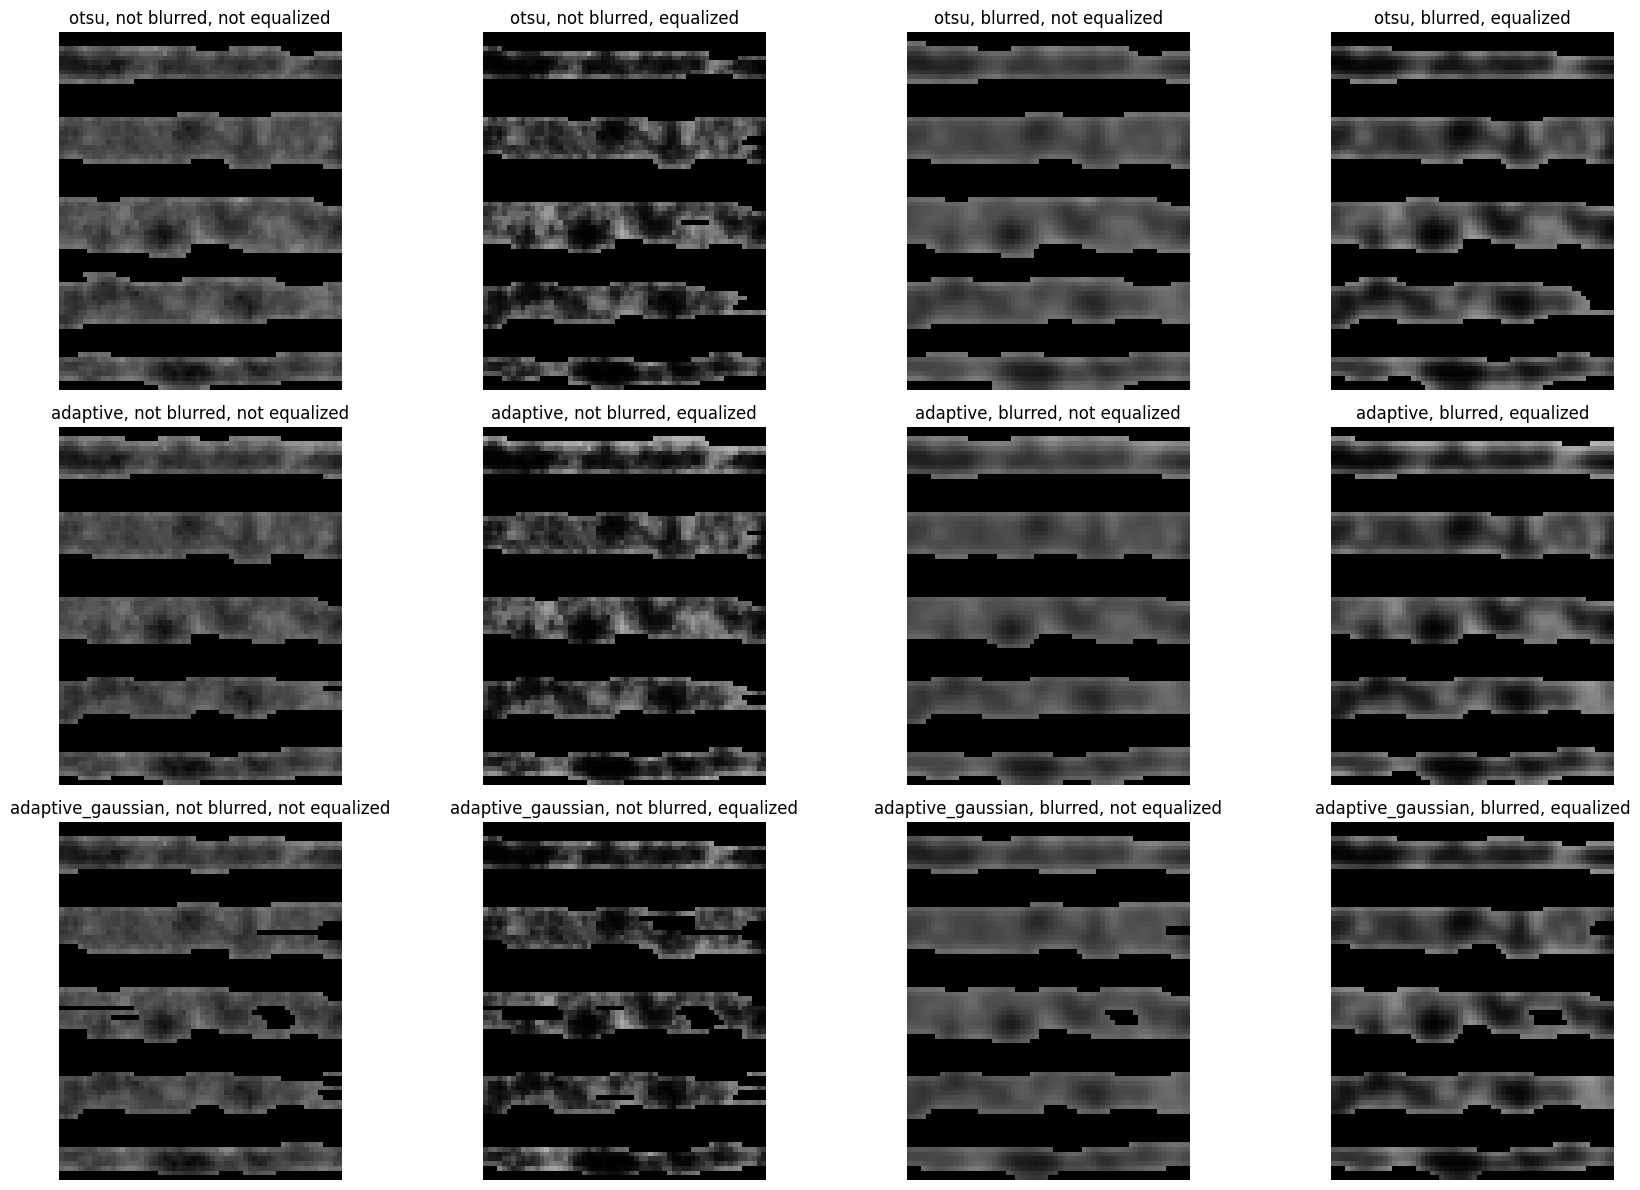

Loading image from output/trial_1/rois/strip_161.png
Image shape: (113, 60)


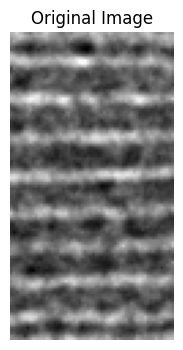

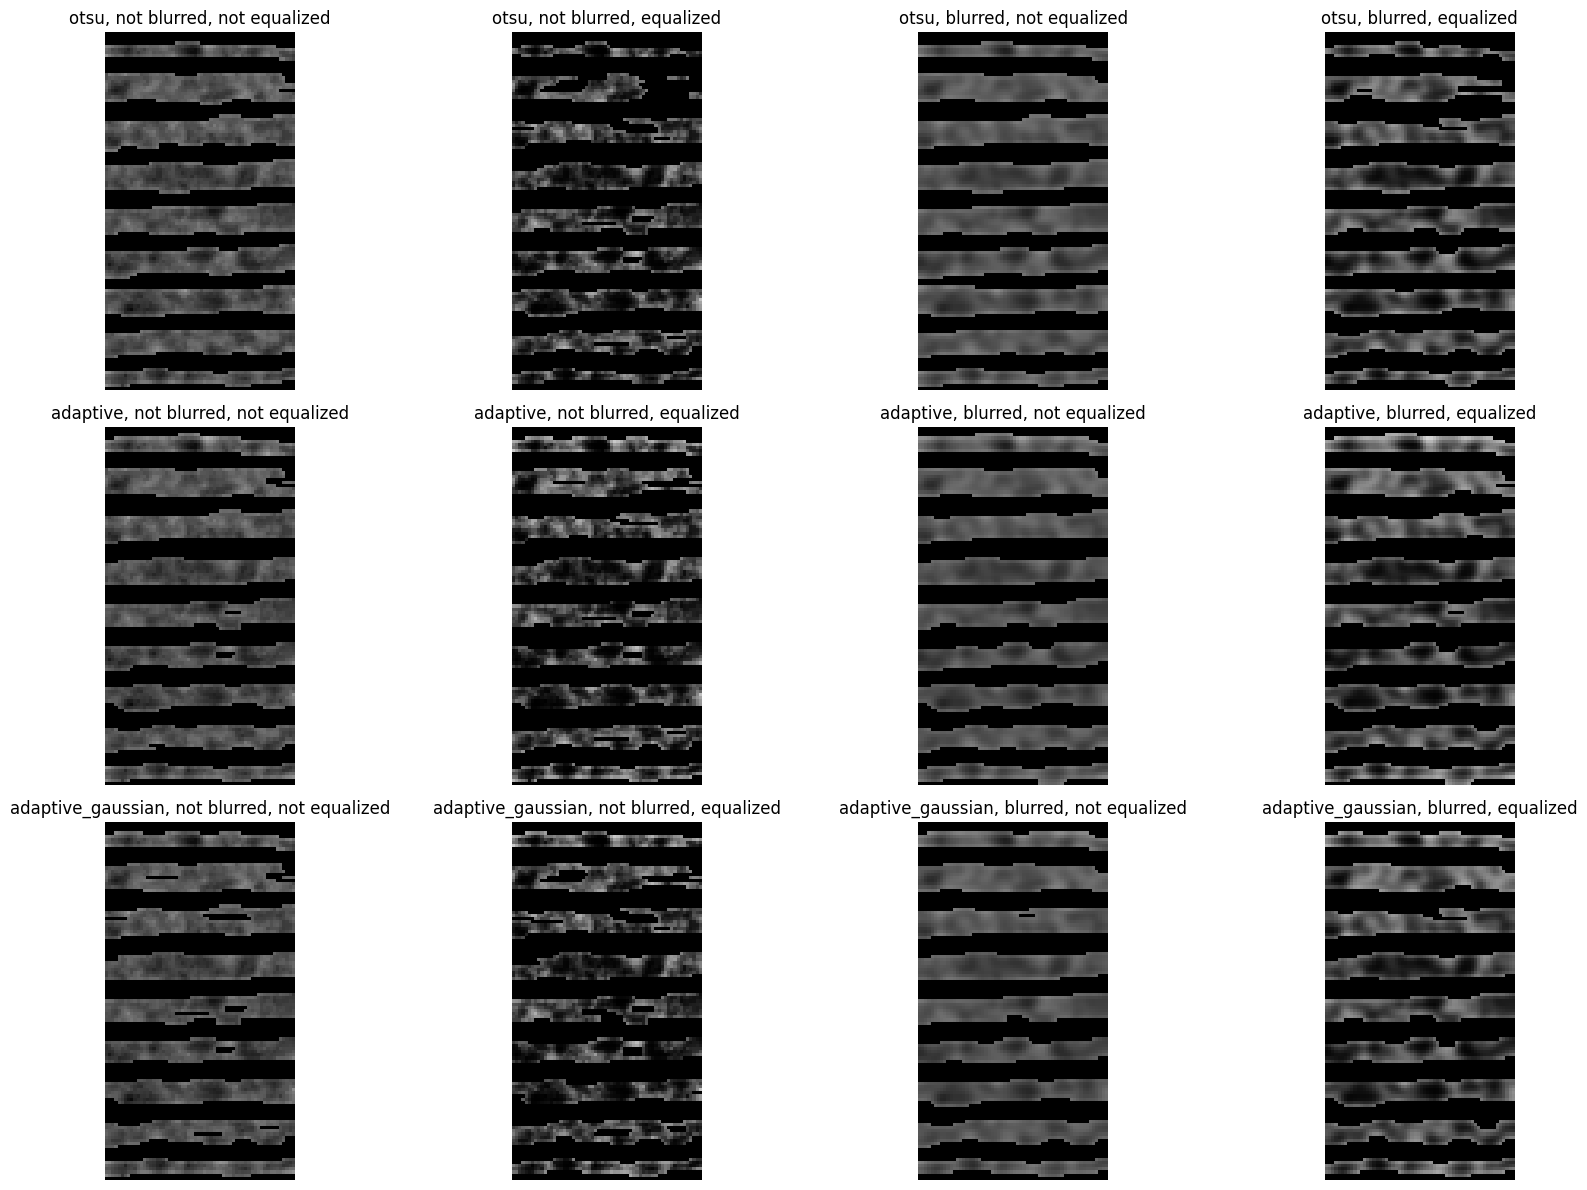

Loading image from output/trial_1/rois/strip_176.png
Image shape: (94, 60)


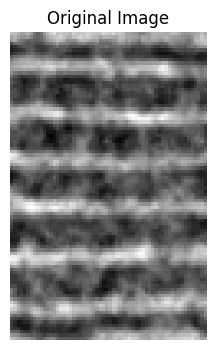

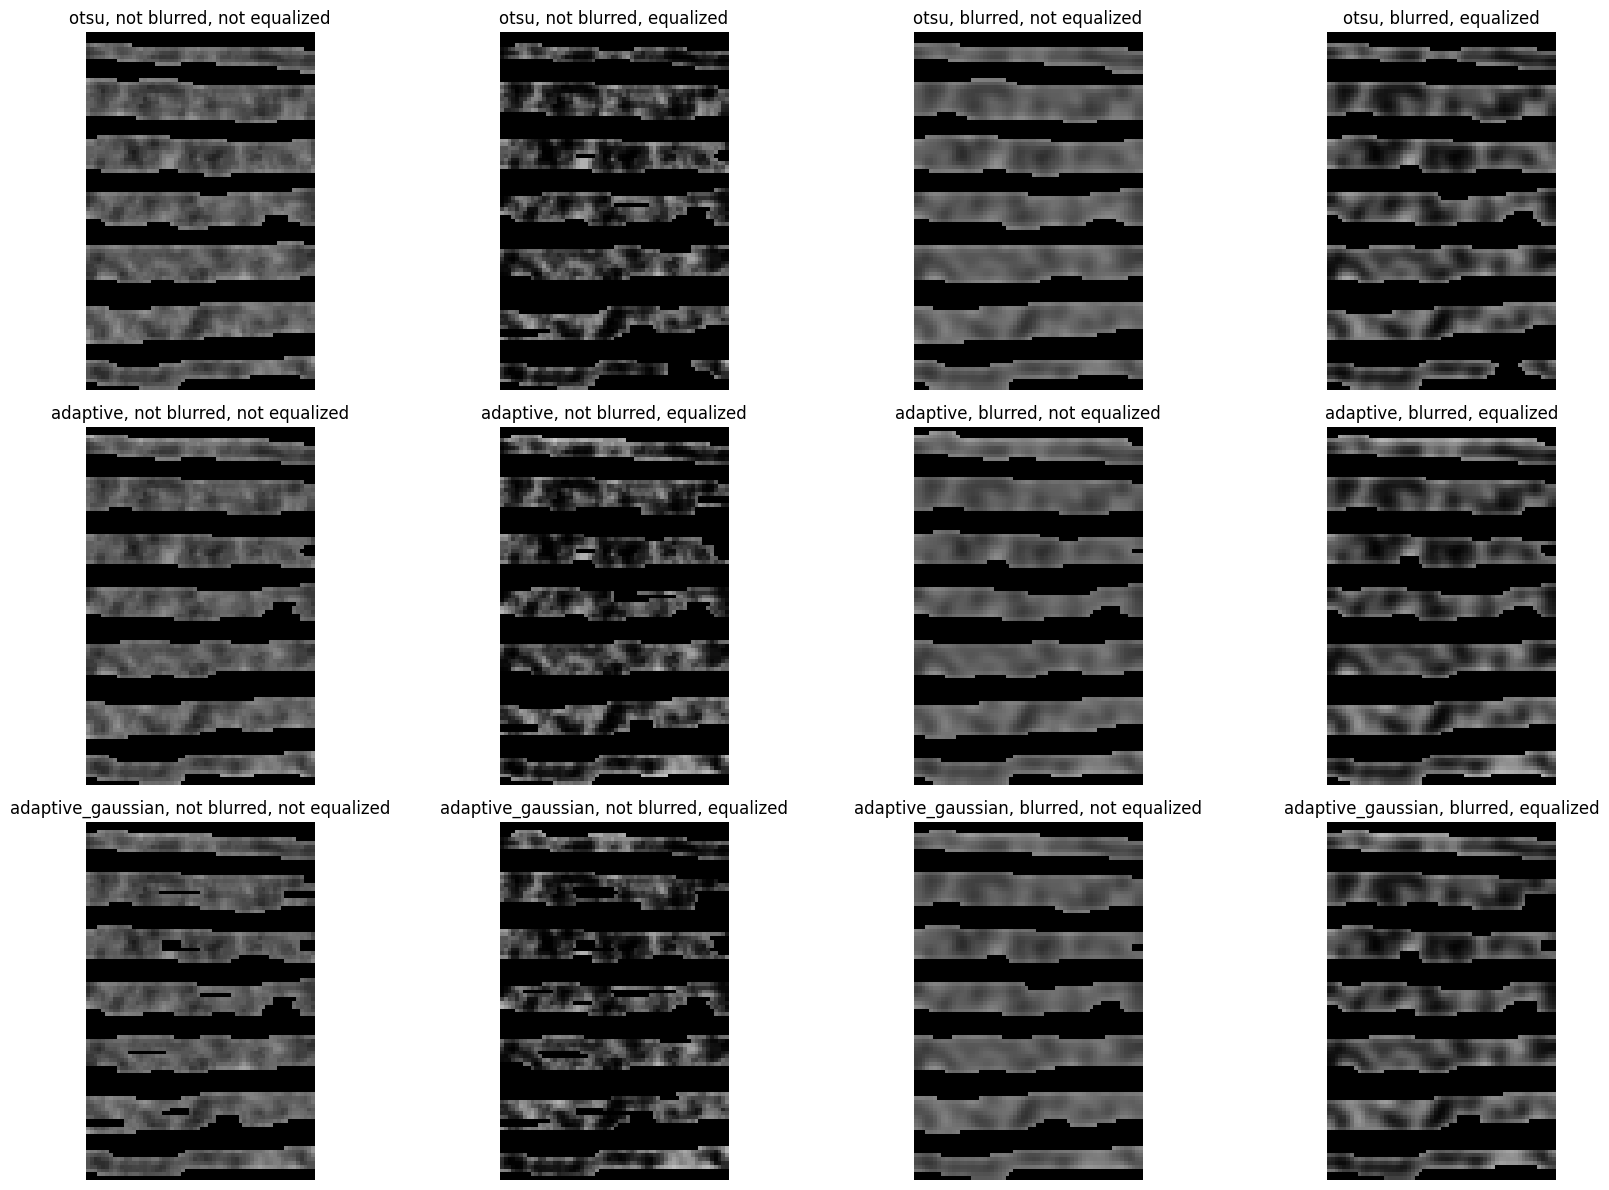

Loading image from output/trial_1/rois/strip_187.png
Image shape: (82, 60)


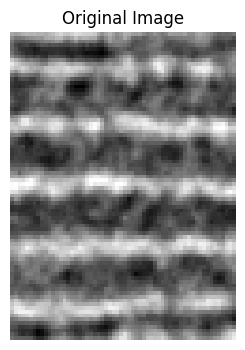

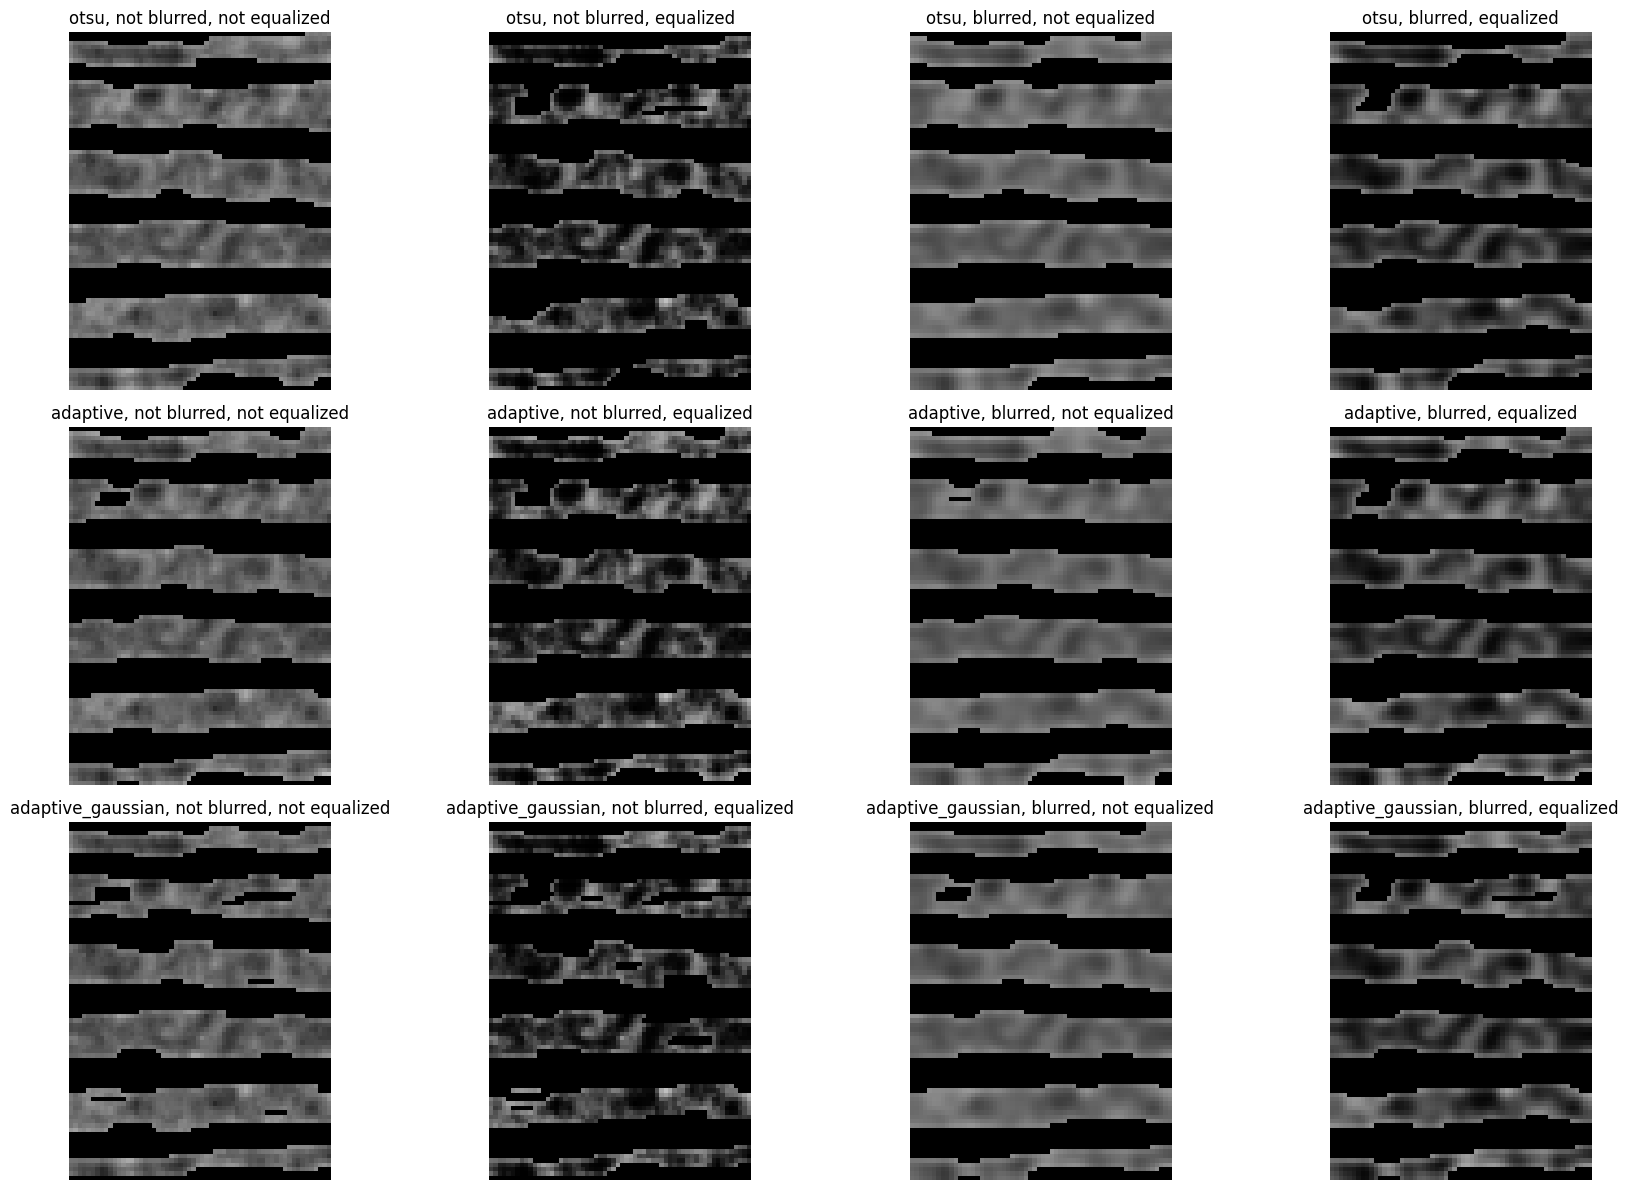

Loading image from output/trial_1/rois/strip_229.png
Image shape: (127, 60)


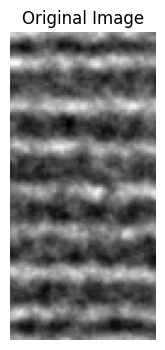

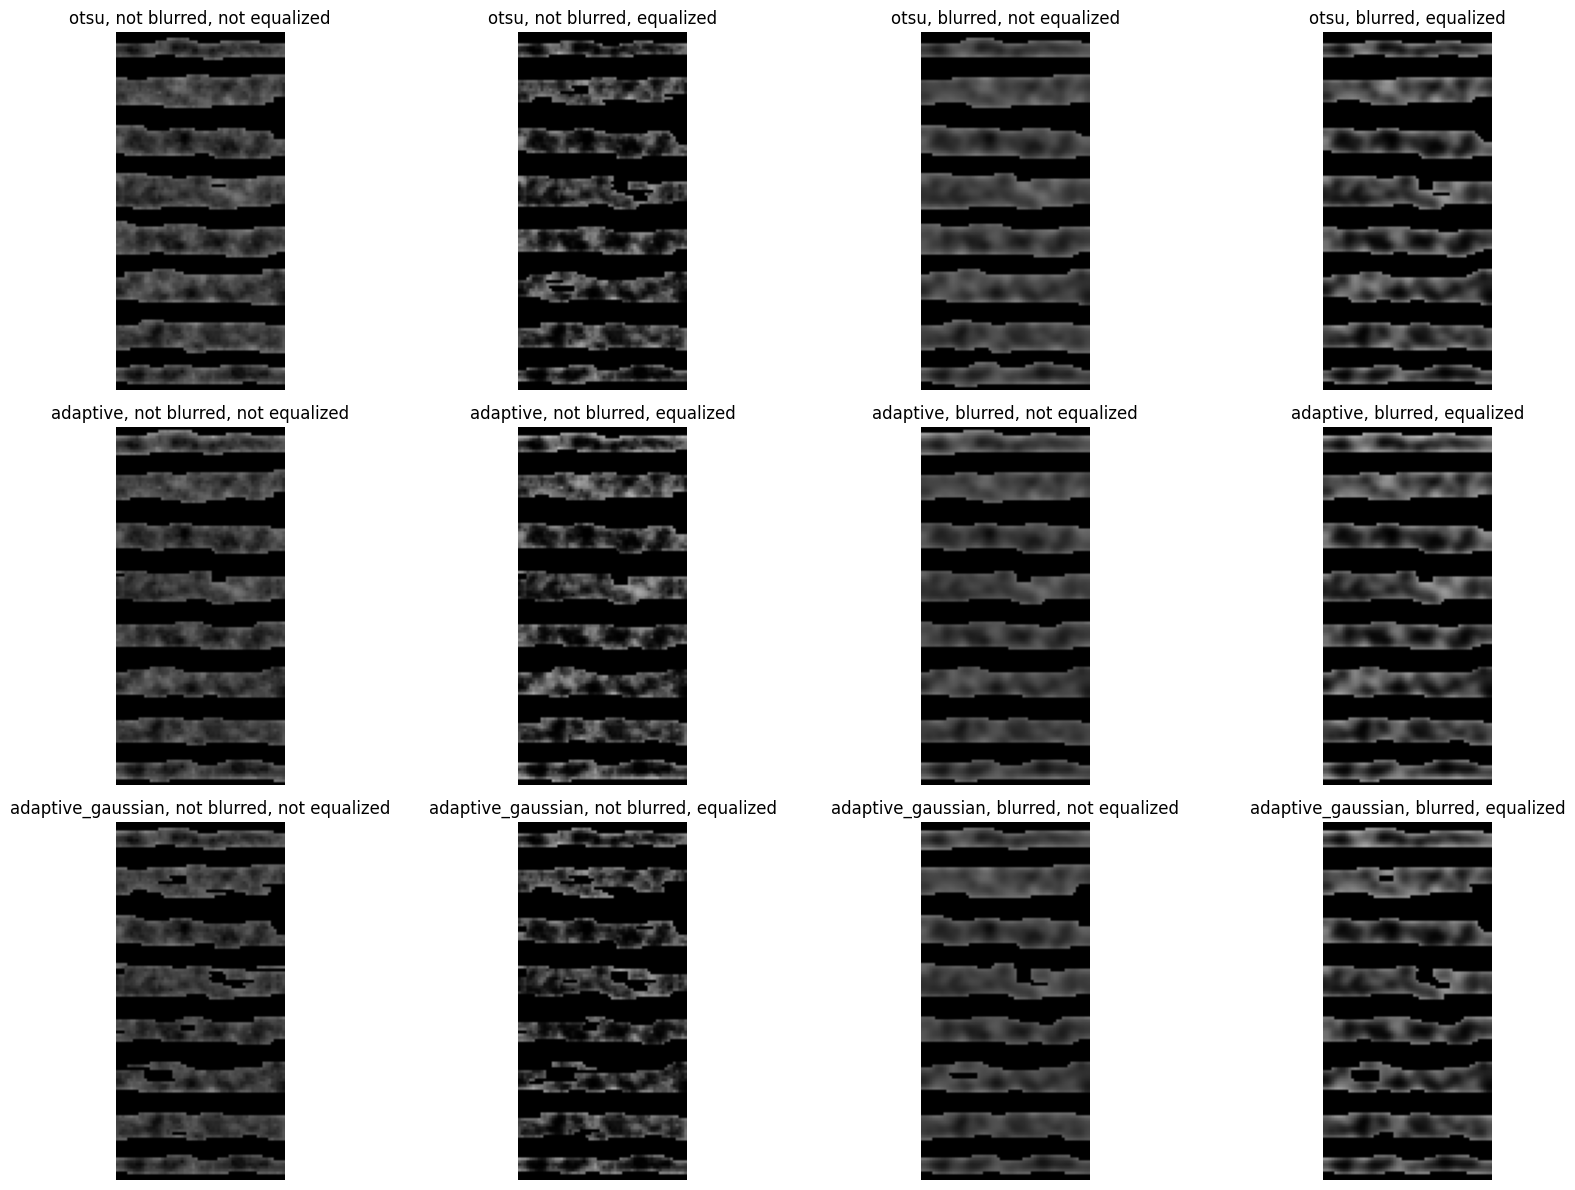

Loading image from output/trial_1/rois/strip_232.png
Image shape: (170, 60)


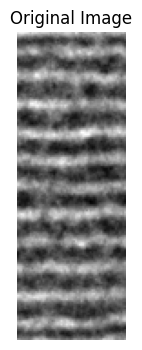

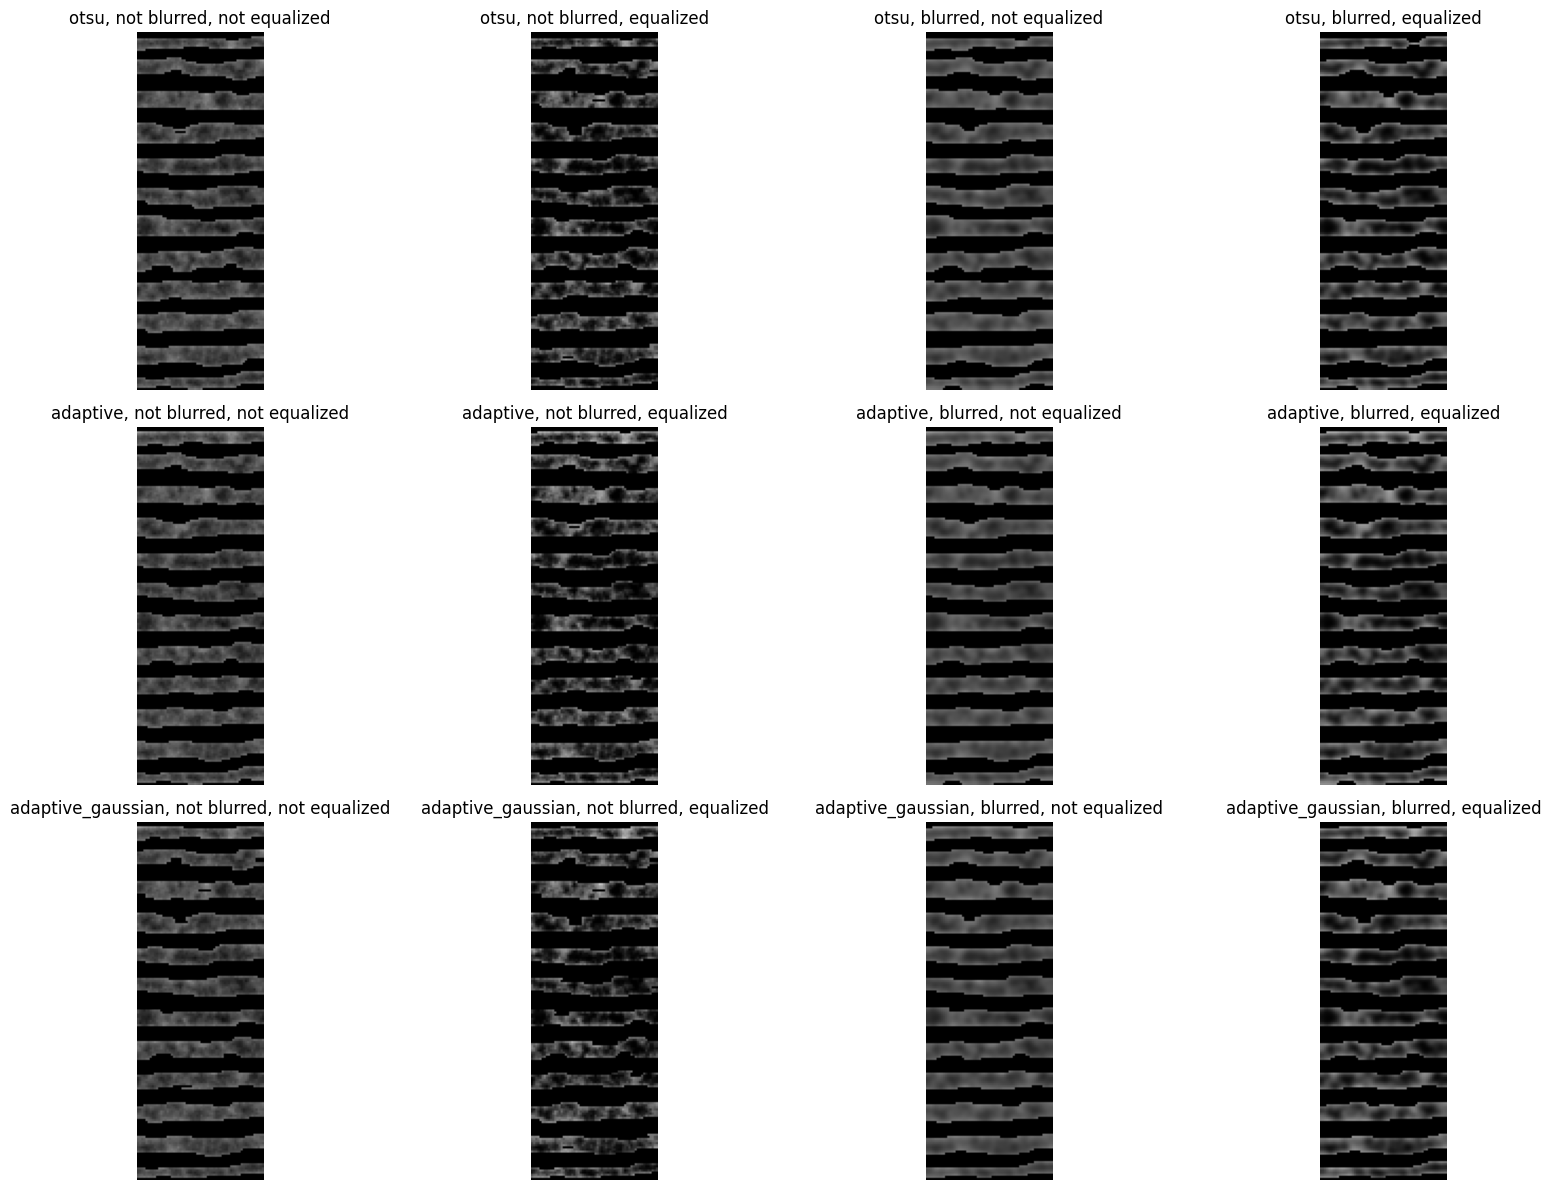

In [9]:

from itertools import product

def get_isolated_membrane(image, method, blur=True, equalize=True, metadata=None):
    processed = process_image(image, method, blur=blur, equalize=equalize, metadata=metadata)
    return processed["overlayed"]

os.makedirs(f"{base_path}/threshold_comparison", exist_ok=True)

# get just the isolated membrane for combinations of these factors:
methods = ["otsu", "adaptive", "adaptive_gaussian"]
equalizes = [False, True]
blurs = [False, True]

# Helmut chose 9 strips
chosen_strip_numbers = [101, 106, 134, 135, 161, 176, 187, 229, 232]

for strip_num in chosen_strip_numbers:
    
    combinations = product(methods, blurs, equalizes)
    strip_filename = roi_metadata[roi_metadata['strip'] == strip_num]['strip_filename'].values[0]
    metadata = roi_metadata[roi_metadata['strip'] == strip_num]
    image = load_gray_image(image_dir + strip_filename)

    # print otu the shape of the images
    print(f"Image shape: {image.shape}")

    # plot them all together in one image so we can compare them. 
    # make sure each has a title so we know what we are looking at
    # the first image is the original image, and will be the only image in row 1

    combo_images = []

    for method, blur, equalize in combinations:

        title = f"{method}, {'blurred' if blur else 'not blurred'}, {'equalized' if equalize else 'not equalized'}"
        isolated_membrane = get_isolated_membrane(image, method, blur=blur, equalize=equalize, metadata=metadata)
        
        combo_images.append((title, isolated_membrane))

    # plot only the original image
    plt.figure(figsize=(4, 4), facecolor='white')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")
    plt.show()
    plt.close()

    # plot the isolated membranes, with a white background
    fig, axes = plt.subplots(3, 4, figsize=(18, 12), facecolor='white')

    for i, (title, isolated_membrane) in enumerate(combo_images):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(isolated_membrane, cmap='gray')
        axes[row, col].set_title(title)
        axes[row, col].axis('off')
        
    plt.tight_layout()
    plt.savefig(f"{base_path}/threshold_comparison/strip_{strip_num}_isolated_membranes.png", dpi=300, facecolor='white')
    plt.show()
    plt.close()